## Стратегии исследования в Q-обучении

В этой тетрадке воспользуемся ранее реализованным алгоритмом Q-обучения и адаптируем алгоритмы исследования из тетрадки по бандитам, чтобы посмотреть, насколько наблюдаемые результаты переносятся в MDP-постановку.

Для обучения будем использовать среды [Taxi-v3](https://gymnasium.farama.org/environments/toy_text/taxi/) и [Boulder](https://sites.google.com/view/edu-gym/environments/bouldering?authuser=0).

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 4.0 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

from numpy.random import Generator
from IPython.display import clear_output

%matplotlib inline

In [3]:
def show_progress(rewards_batch, log):
    """Функция отображения прогресса обучения."""
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.plot(log, label='Avg returns')
    plt.legend(loc=4)
    plt.show()

Ниже адаптируйте заготовку, взятую из тетради с бандитами, под алгоритм Q-обучения. Как и в том задании, реализация агента будет поддерживать одновременно все возможныые стратегии исследования. Выбор происходит по тому, какие из гиперпараметров активны:
- если `random() < eps * decay`, действие выбирается случайно (для случайной, eps-жадной и eps-жадной с затуханием), иначе
- если `softmax_t_inv > 0`, выбор производится по softmax с `t_inv = softmax_t_inv * T_decay ^ softmax_t_decay` обратной температурой (softmax стратегия)
- иначе выбираем жадно на основе значений `Q[s, a] + u[a]`, где `u`:
  - вычисляется по UCB, если `ucb_const > 0` (UCB стратегия),
  - иначе берется `u = 0` (жадная, вторая часть eps-жадной и eps-жадной с затуханием)

(2 балла)

In [4]:
def softmax(xs, inv_temp=1.):
    exp_xs = np.exp((xs - xs.max()) * inv_temp)
    return exp_xs / exp_xs.sum()

class Agent:
    def __init__(
        self, name, n_states, n_actions, *, seed,
        lr, gamma,
        eps=0., eps_decay=1.,
        ucb_const=0.,
        softmax_t_inv=0., softmax_t_decay=0.,
    ):
        self.name = name
        self.eps = eps
        self.eps_decay = eps_decay
        self.ucb_const = ucb_const
        self.softmax_t_inv = softmax_t_inv
        self.softmax_t_decay = softmax_t_decay

        self.lr = lr
        self.gamma = gamma

        self.Q = np.zeros((n_states, n_actions))
        self.n = np.ones_like(self.Q)
        self.T = np.prod(self.n.shape)
        self.T_decay = 0

        self.rng = np.random.default_rng(seed)

    def update(self, s, a, r, next_s, done):
        lr, gamma = self.lr, self.gamma
        target = r if done else r + gamma * np.max(self.Q[next_s])
        td_error = target - self.Q[s, a]
        self.Q[s, a] += lr * td_error

    def _update_visitations(self, s, a):
        self.n[s, a] += 1
        self.T += 1

    def act(self, state):
        rng = self.rng
        n_actions = self.Q.shape[-1]

        current_eps = self.eps * (self.eps_decay ** self.T_decay)

        if current_eps > 0 and rng.uniform(0, 1) < current_eps:
            action = rng.integers(0, n_actions)
        elif self.softmax_t_inv > 0:
            T_inv = self.softmax_t_inv * ((self.T + 1) ** self.softmax_t_decay)
            action_dist = softmax(self.Q[state], T_inv)
            action = rng.choice(n_actions, p=action_dist)
        else:
            if self.ucb_const > 0:
                ucb_values = self.Q[state] + self.ucb_const * np.sqrt(np.log(self.T + 1) / (self.n[state] + 1e-8))
                action = np.argmax(ucb_values)
            else:
                action = np.argmax(self.Q[state])

        self._update_visitations(state, action)
        return action

    def decay_eps(self):
        self.T_decay += 1

    @property
    def exploration_param(self):
        if self.eps > 0:
            return self.eps * (self.eps_decay ** self.T_decay)
        elif self.softmax_t_inv > 0:
            return self.softmax_t_inv * ((self.T + 1) ** self.softmax_t_decay)
        elif self.ucb_const > 0:
            return np.mean(np.sqrt(self.ucb_const * np.log(self.T + 1) / (self.n + 1e-8)))
        return 0

(1 балл)

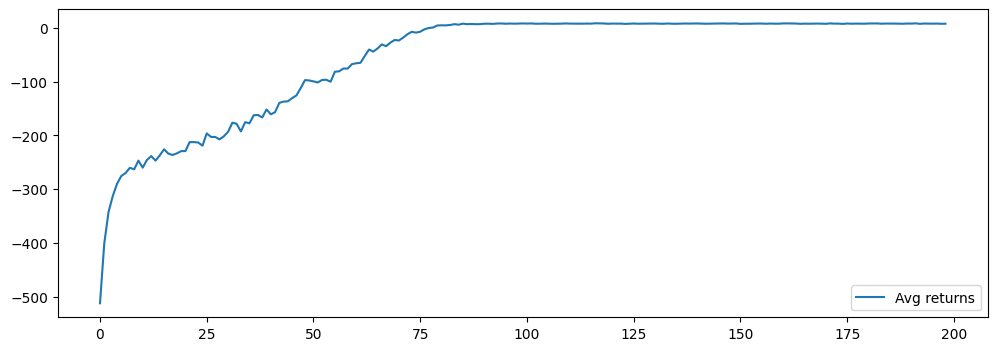

100%|██████████| 5/5 [07:14<00:00, 86.96s/it]


In [7]:
from tqdm import tqdm

seed = 41
env = gym.make('Taxi-v3', max_episode_steps=200)

n_states, n_actions = env.observation_space.n, env.action_space.n


lr = 0.02
gamma = 0.97
eps_decay, ucb_const = .998, 2.
softmax_t_inv, softmax_t_decay = 0.2, 0.6
n_steps, schedule = 1_000_000, 5_000

agent_random = Agent('rand', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=1.)
agent_eps_greedy25 = Agent('eps-greedy_0.25', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=0.25)
agent_eps_greedy5 = Agent('eps-greedy_0.05', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=0.05)
agent_eps_greedy_decayed = Agent('eps-greedy-dec', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=1.0, eps_decay=eps_decay)
agent_ucb = Agent('ucb', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, ucb_const=ucb_const)
agent_softmax = Agent('softmax', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, softmax_t_inv=softmax_t_inv, softmax_t_decay=softmax_t_decay)

agents = [
    agent_eps_greedy25,
    agent_eps_greedy5,
    agent_eps_greedy_decayed,
    agent_ucb,
    agent_softmax,
]

log = []
for agent in tqdm(agents):
    log.append([])
    agent_returns = None
    step, ep = 0, 1
    while step < n_steps:
        state, _ = env.reset()
        ep_ret = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.update(state, action, reward, next_state, done)

            state = next_state
            ep_ret += reward
            step += 1

            if step >= n_steps:
                break

            if step % schedule == 0:
                show_progress(agent_returns, log[-1])

        ep += 1
        agent.decay_eps()
        if agent_returns is None:
            agent_returns = ep_ret
        agent_returns = agent_returns + 0.02 * (ep_ret - agent_returns)

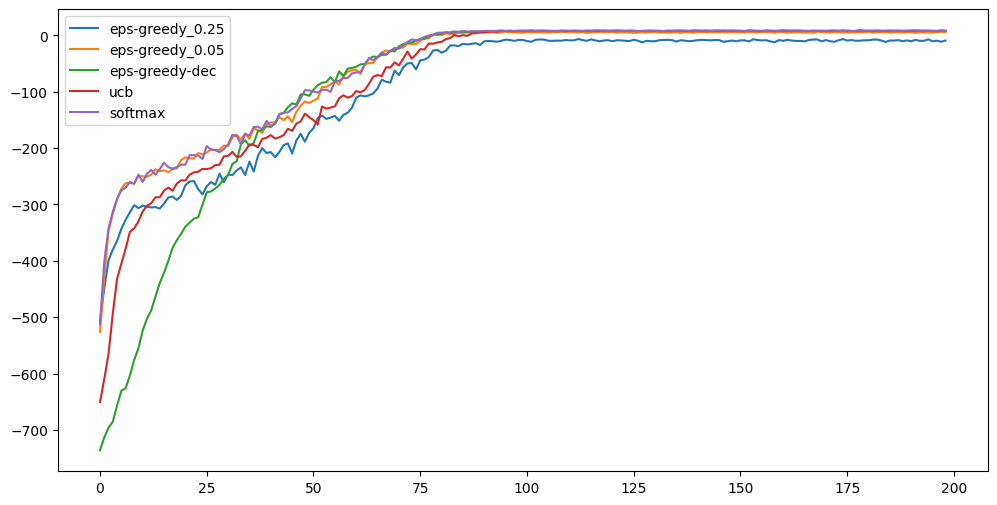

In [8]:
# Compare results
plt.figure(figsize=[12, 6])
for agent_log in log:
    _ = plt.plot(agent_log)
plt.legend([agent.name for agent in agents])

(1 балл)

**Вопросы**: Что можно сказать о динамике исследования агентом? Какие из исследовательских стратегий более универсальны с точки зрения подбора гиперпараметров под среду?

**Ответы**: В нашем случае алгоритмы отработали примерно одинаково, но можно заметить, что ϵ-жадные алгоритмы сильно зависят от гипермараметра. Самым универсальным можно назвать UCB, так как он почти не требует подбора гиперпараметров.


### Bouldering

Давайте попробуем проверить реализованные алгоритмы в среде Boulder, которая требует от агента выполнить определенную последовательность действий (при выборе неверного действия в состоянии, он "падает" в начало, эпизод при этом продолжается). Сложность среды определяется высотой (=число состояний) и шириной трассы (=число действий).

Для отладки, имеет смысл взять сначала небольшие значения (например, h=3, w=2) и постепенно увеличивать их.

In [12]:
from gymnasium import spaces

class BoulderEnv(gym.Env):
    metadata = {"render_modes": ["terminal", "human"]}
    def __init__(self, render_mode=None, height=10, n_grips=2, max_steps=1000, success_prob=0.0):
        '''
        |- |
        |- |   '-': grip
        | -|   '*': agent
        | -|
        _*__
        '''
        self.height = height
        self.n_grips = n_grips
        self.max_steps = max_steps
        self.steps_taken = 0
        self.success_prob = success_prob

        # Observation is the current height of the agent.
        self.observation_space = spaces.Discrete(self.height+1)

        # We have n_grips actions, every time the agent needs to grip the right grips
        self.action_space = spaces.Discrete(self.n_grips)

        self.pygame_initialized = False

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.reset()

    def _get_initial_loc(self):
        return 0

    def _get_obs(self):
        return self._agent_location

    def render(self):
        pass

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Initialize positions of grips
        self._agent_location = self._get_initial_loc()
        self.grips = self.np_random.choice(self.n_grips, self.height)
        self.steps_taken = 0

        observation = self._get_obs()

        return observation, {}

    def step(self, action):
        # if the action match the given grip
        if action == self.grips[self._agent_location]:
            self._agent_location += 1
        elif self.np_random.random() < self.success_prob:
            # got lucky
            self._agent_location += 1
        else:
            self._agent_location = self._get_initial_loc()

        if self._agent_location == self.height:
            # print("REACHED THE TARGET")
            reward = 1
            terminated = True
            truncated = False
        else:
            reward = 0
            terminated = False
            truncated = False

        self.steps_taken += 1

        if self.steps_taken == self.max_steps:
            # print("MAX STEPS IS REACHED")
            terminated = False
            truncated = True

        observation = self._get_obs()

        return observation, reward, terminated, truncated, {}

gym.register(
    id=f"Boulder-v0",
    entry_point="__main__:BoulderEnv",
)

In [13]:
env = gym.make("Boulder-v0")
env.reset()

(0, {})

(1 балл)

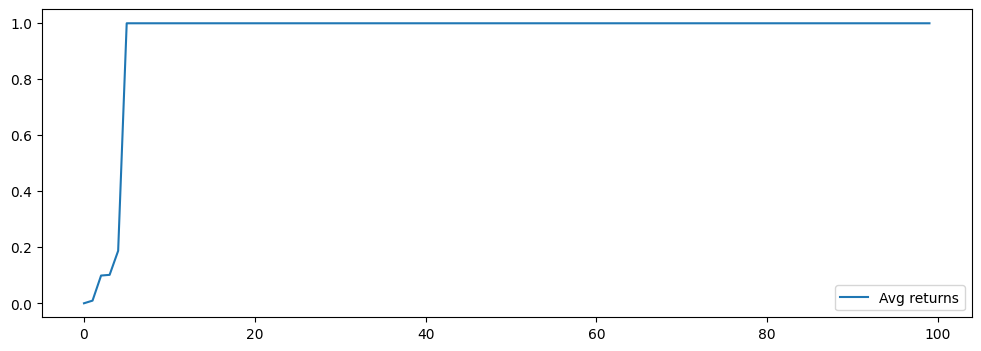

100%|██████████| 6/6 [04:46<00:00, 47.72s/it]


In [22]:
seed = 41
env = gym.make('Boulder-v0', height=7, n_grips=4, success_prob=0.05, max_episode_steps=200)

n_states, n_actions = env.observation_space.n, env.action_space.n

# гиперпараметры алгоритма
lr = 0.02
gamma = 0.98
eps_decay, ucb_const = .9992, 2.
softmax_t_inv, softmax_t_decay=0.2, 0.6
n_steps, schedule = 1_000_000, 10_000

agent_random = Agent('rand', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=1.)
agent_eps_greedy25 = Agent('eps-greedy_0.25', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=0.25)
agent_eps_greedy5 = Agent('eps-greedy_0.05', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=0.05)
agent_eps_greedy_decayed = Agent('eps-greedy-dec', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=1.0, eps_decay=eps_decay)
agent_ucb = Agent('ucb', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, ucb_const=ucb_const)
agent_softmax = Agent('softmax', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, softmax_t_inv=softmax_t_inv, softmax_t_decay=softmax_t_decay)

agents = [
    agent_random,
    agent_eps_greedy25,
    agent_eps_greedy5,
    agent_eps_greedy_decayed,
    agent_ucb,
    agent_softmax,
]

log = []
for agent in tqdm(agents):
    log.append([])
    agent_returns = None
    step, ep = 0, 1
    while step < n_steps:
        s, _ = env.reset(seed=seed)
        ep_ret = 0
        done = False
        while not done and step < n_steps:
            a = agent.act(s)
            n, r, term, trunc, _ = env.step(a)
            done = term or trunc

            agent.update(s, a, r, n, done)

            s = n
            ep_ret += r
            step += 1

            if step % schedule == 0:
                show_progress(agent_returns, log[-1])


        ep += 1
        agent.decay_eps()
        if agent_returns is None:
            agent_returns = ep_ret
        agent_returns += 0.02 * (ep_ret - agent_returns)

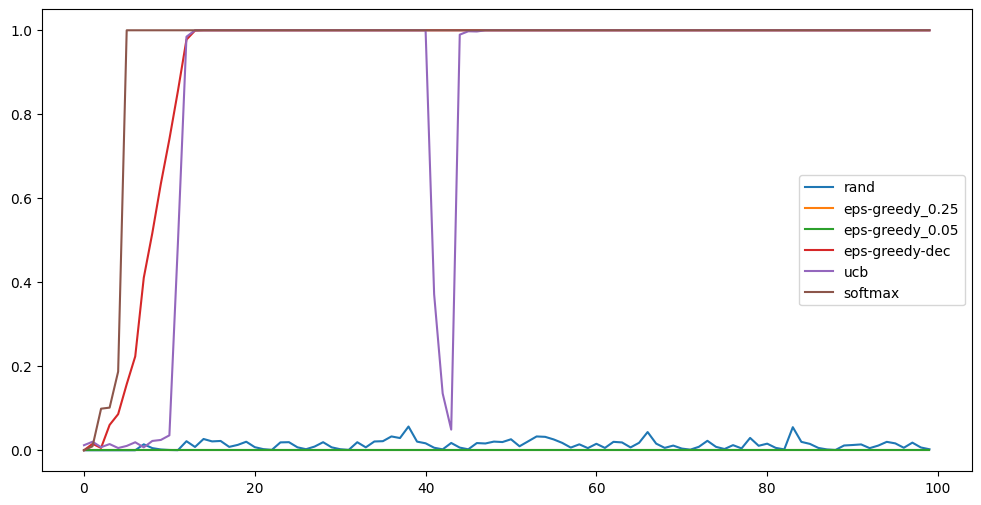

In [23]:
# Compare results
plt.figure(figsize=[12, 6])
for agent_log in log:
    _ = plt.plot(agent_log)
plt.legend([agent.name for agent in agents])

(1 балл)

**Вопросы**: Почему стратегии с константной eps-жадностью сильно деградируют с ростом сложности задачи?
**Ответы**: Выбирать случайное действие выгодно на начальных этапах, чтобы исследовать среду. Далее выбирать случайное действие довольно глупо, так как случайное действие с большой вероятностью ошибочно.